<a href="https://colab.research.google.com/github/z-mrainbow/homework/blob/main/CIFAR-10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip /content/drive/MyDrive/test.zip -d /content

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/test/test/95499.png  
  inflating: /content/test/test/955.png  
  inflating: /content/test/test/9550.png  
  inflating: /content/test/test/95500.png  
  inflating: /content/test/test/95501.png  
  inflating: /content/test/test/95502.png  
  inflating: /content/test/test/95503.png  
  inflating: /content/test/test/95504.png  
  inflating: /content/test/test/95505.png  
  inflating: /content/test/test/95506.png  
  inflating: /content/test/test/95507.png  
  inflating: /content/test/test/95508.png  
  inflating: /content/test/test/95509.png  
  inflating: /content/test/test/9551.png  
  inflating: /content/test/test/95510.png  
  inflating: /content/test/test/95511.png  
  inflating: /content/test/test/95512.png  
  inflating: /content/test/test/95513.png  
  inflating: /content/test/test/95514.png  
  inflating: /content/test/test/95515.png  
  inflating: /content/test/test/95516.png  
  inflating: /content/test/test/95517.png  
  inflati

In [2]:
!unzip /content/drive/MyDrive/train.zip -d /content

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/train/train/5499.png  
  inflating: /content/train/train/55.png  
  inflating: /content/train/train/550.png  
  inflating: /content/train/train/5500.png  
  inflating: /content/train/train/5501.png  
  inflating: /content/train/train/5502.png  
  inflating: /content/train/train/5503.png  
  inflating: /content/train/train/5504.png  
  inflating: /content/train/train/5505.png  
  inflating: /content/train/train/5506.png  
  inflating: /content/train/train/5507.png  
  inflating: /content/train/train/5508.png  
  inflating: /content/train/train/5509.png  
  inflating: /content/train/train/551.png  
  inflating: /content/train/train/5510.png  
  inflating: /content/train/train/5511.png  
  inflating: /content/train/train/5512.png  
  inflating: /content/train/train/5513.png  
  inflating: /content/train/train/5514.png  
  inflating: /content/train/train/5515.png  
  inflating: /content/train/train/5516.png  
  inflating: /content/train/trai

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from tqdm import tqdm
import os
import pickle
import random
from collections import defaultdict
from PIL import Image


# 设置随机种子
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)

# CIFAR-10类别标签
CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']


# ================================
# 1. 自定义数据集类（修改版）
# ================================

class CustomCIFAR10Dataset(Dataset):
    """自定义CIFAR-10数据集类，支持从文件夹和CSV加载图片"""

    def __init__(self, data_dir, csv_file=None, transform=None, is_test=False):
        """
        Args:
            data_dir (str): 图片文件夹路径
            csv_file (str): CSV文件路径，包含图片名和标签
            transform: 图像变换
            is_test (bool): 是否为测试集（无标签）
        """
        self.data_dir = data_dir
        self.transform = transform
        self.is_test = is_test
        self.image_paths = []
        self.labels = []

        if is_test:
            # 测试集：直接列出所有图片文件
            print(f"加载测试集从: {data_dir}")
            for img_name in os.listdir(data_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(img_name)
            print(f"测试集图片数量: {len(self.image_paths)}")

        else:
            # 训练集：使用CSV文件
            if csv_file and os.path.exists(csv_file):
                print(f"从CSV文件加载训练数据: {csv_file}")
                df = pd.read_csv(csv_file)
                print(f"CSV文件列名: {list(df.columns)}")

                # 假设CSV格式：第一列是图片名（不带扩展名），第二列是标签
                for idx, row in df.iterrows():
                    img_name = str(row.iloc[0])  # 第一列：图片名
                    label_name = str(row.iloc[1])  # 第二列：标签名

                    # 尝试不同的图片扩展名
                    img_found = False
                    for ext in ['.png', '.jpg', '.jpeg']:
                        img_path = os.path.join(data_dir, img_name + ext)
                        if os.path.exists(img_path):
                            self.image_paths.append(img_name + ext)
                            # 将标签名转换为数字
                            if label_name in CIFAR10_CLASSES:
                                self.labels.append(CIFAR10_CLASSES.index(label_name))
                            else:
                                print(f"未知标签: {label_name}")
                                self.labels.append(0)  # 默认为第一个类别
                            img_found = True
                            break

                    if not img_found:
                        print(f"图片不存在: {img_name}")

            else:
                # 如果没有CSV文件，尝试从文件夹结构读取
                print(f"从文件夹结构加载训练数据: {data_dir}")
                # 检查是否有子文件夹（按类别组织）
                has_subfolders = any(os.path.isdir(os.path.join(data_dir, item))
                                     for item in os.listdir(data_dir))

                if has_subfolders:
                    # 按类别文件夹组织
                    for class_idx, class_name in enumerate(CIFAR10_CLASSES):
                        class_dir = os.path.join(data_dir, class_name)
                        if os.path.exists(class_dir):
                            for img_name in os.listdir(class_dir):
                                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                                    self.image_paths.append(os.path.join(class_name, img_name))
                                    self.labels.append(class_idx)
                else:
                    # 所有图片在同一文件夹，无法获取标签
                    print("警告：无CSV文件且无子文件夹结构，无法获取标签信息")
                    for img_name in os.listdir(data_dir):
                        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                            self.image_paths.append(img_name)
                            self.labels.append(0)  # 默认标签

        print(f"数据集大小: {len(self.image_paths)}")
        if not is_test:
            print(f"标签数量: {len(self.labels)}")
            if len(self.labels) > 0:
                print(f"标签分布: {dict(zip(*np.unique(self.labels, return_counts=True)))}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 构建完整图片路径
        img_path = os.path.join(self.data_dir, self.image_paths[idx])

        # 加载图片
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"加载图片失败: {img_path}, 错误: {e}")
            # 返回黑色图片作为备选
            image = Image.new('RGB', (32, 32), (0, 0, 0))

        # 应用变换
        if self.transform:
            image = self.transform(image)

        if self.is_test:
            # 返回原始文件名（去掉扩展名，用于submission）
            img_name = os.path.splitext(self.image_paths[idx])[0]
            return image, img_name
        else:
            label = self.labels[idx]
            return image, label


class CustomDataModule:
    def __init__(self, train_dir, test_dir, train_csv=None, batch_size=128, num_workers=2):
        """
        Args:
            train_dir: 训练数据文件夹路径
            test_dir: 测试数据文件夹路径
            train_csv: 训练数据CSV文件路径（可选）
            batch_size: 批量大小
            num_workers: 数据加载线程数（减少以避免错误）
        """
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.train_csv = train_csv
        self.batch_size = batch_size
        self.num_workers = num_workers

        # 数据增强策略
        self.train_transform = transforms.Compose([
            transforms.Resize((32, 32)),  # 确保图片大小为32x32
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.025),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])

        self.test_transform = transforms.Compose([
            transforms.Resize((32, 32)),  # 确保图片大小为32x32
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])

    def get_dataloaders(self):
        # 创建训练数据集
        train_dataset = CustomCIFAR10Dataset(
            data_dir=self.train_dir,
            csv_file=self.train_csv,
            transform=self.train_transform,
            is_test=False
        )

        # 创建测试数据集
        test_dataset = CustomCIFAR10Dataset(
            data_dir=self.test_dir,
            transform=self.test_transform,
            is_test=True
        )

        # 创建数据加载器
        train_loader = DataLoader(
            train_dataset, batch_size=self.batch_size,
            shuffle=True, num_workers=self.num_workers, pin_memory=True)

        test_loader = DataLoader(
            test_dataset, batch_size=self.batch_size,
            shuffle=False, num_workers=self.num_workers, pin_memory=True)

        return train_loader, test_loader

    def get_validation_split(self, val_ratio=0.2):
        """从训练集中分离出验证集"""
        train_dataset = CustomCIFAR10Dataset(
            data_dir=self.train_dir,
            csv_file=self.train_csv,
            transform=self.train_transform,
            is_test=False
        )

        # 计算分割点
        total_size = len(train_dataset)
        val_size = int(total_size * val_ratio)
        train_size = total_size - val_size

        # 随机分割
        train_subset, val_subset = torch.utils.data.random_split(
            train_dataset, [train_size, val_size])

        # 为验证集创建新的数据集实例（使用测试变换）
        val_dataset = CustomCIFAR10Dataset(
            data_dir=self.train_dir,
            csv_file=self.train_csv,
            transform=self.test_transform,
            is_test=False
        )

        # 创建验证集的子集
        val_subset_indices = val_subset.indices
        val_images = [val_dataset.image_paths[i] for i in val_subset_indices]
        val_labels = [val_dataset.labels[i] for i in val_subset_indices]

        # 重新创建验证数据集
        val_dataset.image_paths = val_images
        val_dataset.labels = val_labels

        train_loader = DataLoader(
            train_subset, batch_size=self.batch_size,
            shuffle=True, num_workers=self.num_workers, pin_memory=True)

        val_loader = DataLoader(
            val_dataset, batch_size=self.batch_size,
            shuffle=False, num_workers=self.num_workers, pin_memory=True)

        return train_loader, val_loader


# ================================
# 2. 模型架构（保持不变）
# ================================

class BasicBlock(nn.Module):
    """ResNet基本块"""
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet18(nn.Module):
    """ResNet-18 for CIFAR-10"""

    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        self.linear = nn.Linear(512 * BasicBlock.expansion, num_classes)
        self.dropout = nn.Dropout(0.5)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.linear(out)
        return out


# ================================
# 3. 训练器类（保持不变）
# ================================

class CIFAR10Trainer:
    def __init__(self, model, device='cuda'):
        self.model = model.to(device)
        self.device = device
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

    def train_epoch(self, train_loader, optimizer, criterion):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc='Training')
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(self.device), target.to(self.device)

            optimizer.zero_grad()
            output = self.model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            pbar.set_postfix({
                'Loss': f'{running_loss / (batch_idx + 1):.4f}',
                'Acc': f'{100. * correct / total:.2f}%'
            })

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        return epoch_loss, epoch_acc

    def validate(self, val_loader, criterion):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in tqdm(val_loader, desc='Validation'):
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                loss = criterion(output, target)

                running_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        epoch_loss = running_loss / len(val_loader)
        epoch_acc = 100. * correct / total
        return epoch_loss, epoch_acc

    def train(self, train_loader, val_loader, epochs=100, lr=0.001):
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        criterion = nn.CrossEntropyLoss()

        best_acc = 0
        patience = 10
        patience_counter = 0

        print(f"开始训练，共 {epochs} 个epoch")
        print("-" * 50)

        for epoch in range(epochs):
            print(f'Epoch {epoch + 1}/{epochs}')

            train_loss, train_acc = self.train_epoch(train_loader, optimizer, criterion)
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc)

            val_loss, val_acc = self.validate(val_loader, criterion)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)

            scheduler.step()

            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
            print("-" * 50)

            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(self.model.state_dict(), 'best_cifar10_model.pth')
                patience_counter = 0
                print(f'新的最佳验证准确率: {best_acc:.2f}%')
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f'验证准确率在 {patience} 个epoch内没有提升，提前停止训练')
                break

        print(f'训练完成! 最佳验证准确率: {best_acc:.2f}%')
        return best_acc


# ================================
# 4. Kaggle提交文件生成器
# ================================

class KaggleSubmission:
    def __init__(self, model, device='cuda'):
        self.model = model.to(device)
        self.device = device

    def generate_submission(self, test_loader, output_file='submission.csv'):
        """生成Kaggle提交文件"""
        self.model.eval()
        predictions = []
        image_names = []

        print("正在生成预测结果...")
        with torch.no_grad():
            for data, names in tqdm(test_loader, desc='Generating predictions'):
                data = data.to(self.device)
                outputs = self.model(data)
                _, predicted = torch.max(outputs, 1)

                # 收集预测结果和图片名
                for i, pred in enumerate(predicted):
                    image_names.append(names[i])
                    predictions.append(CIFAR10_CLASSES[pred.item()])

        # 创建提交DataFrame
        submission_df = pd.DataFrame({
            'id': image_names,
            'label': predictions
        })

        # 保存CSV文件
        submission_df.to_csv(output_file, index=False)
        print(f'提交文件已保存到: {output_file}')
        print(f'提交文件包含 {len(submission_df)} 条预测结果')
        print("\n提交文件前5行预览:")
        print(submission_df.head())

        return submission_df


# ================================
# 5. 主函数（修改路径配置）
# ================================

def main():
    """主函数"""
    print("=== 自定义CIFAR-10 图像分类项目 ===\n")

    # ================================
    # 配置路径 - 修改为你的实际路径
    # ================================
    # 修改这些路径为你的实际文件路径
    TRAIN_DIR = "train/train"  # 训练数据文件夹
    TEST_DIR = "test/test"  # 测试数据文件夹
    TRAIN_CSV = "trainLabels.csv"  # 训练标签CSV文件

    # 检查路径是否存在
    if not os.path.exists(TRAIN_DIR):
        print(f"错误: 训练数据文件夹不存在: {TRAIN_DIR}")
        print("请修改 TRAIN_DIR 路径")
        return

    if not os.path.exists(TEST_DIR):
        print(f"错误: 测试数据文件夹不存在: {TEST_DIR}")
        print("请修改 TEST_DIR 路径")
        return

    # 检查GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"使用设备: {device}")

    # 1. 数据准备
    print("\n1. 准备数据...")
    data_module = CustomDataModule(
        train_dir=TRAIN_DIR,
        test_dir=TEST_DIR,
        train_csv=TRAIN_CSV if os.path.exists(TRAIN_CSV) else None,
        batch_size=64,  # 减小batch size以避免内存问题
        num_workers=2  # 减少worker数量
    )

    # 分割训练和验证集
    train_loader, val_loader = data_module.get_validation_split(val_ratio=0.2)

    # 获取测试数据加载器（用于生成submission）
    _, test_loader = data_module.get_dataloaders()

    print(f"训练集大小: {len(train_loader.dataset)}")
    print(f"验证集大小: {len(val_loader.dataset)}")
    print(f"测试集大小: {len(test_loader.dataset)}")

    # 2. 创建模型
    print("\n2. 创建模型...")
    model = ResNet18(num_classes=10)
    print(f"模型参数数量: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    # 3. 训练模型
    print("\n3. 训练模型...")
    trainer = CIFAR10Trainer(model, device)

    # 训练配置
    EPOCHS = 20  # 减少epoch数量用于测试
    LEARNING_RATE = 0.001

    best_acc = trainer.train(train_loader, val_loader, epochs=EPOCHS, lr=LEARNING_RATE)

    # 4. 生成Kaggle提交文件
    print("\n4. 生成Kaggle提交文件...")

    # 加载最佳模型
    if os.path.exists('best_cifar10_model.pth'):
        model.load_state_dict(torch.load('best_cifar10_model.pth'))
        print("已加载最佳模型")

    # 生成提交文件
    kaggle_submitter = KaggleSubmission(model, device)
    submission_df = kaggle_submitter.generate_submission(test_loader, 'submission.csv')

    print(f"\n=== 训练完成 ===")
    print(f"最佳验证准确率: {best_acc:.2f}%")
    print("模型已保存为: best_cifar10_model.pth")
    print("Kaggle提交文件已生成: submission.csv")


if __name__ == "__main__":
    main()

=== 自定义CIFAR-10 图像分类项目 ===

使用设备: cuda

1. 准备数据...
从CSV文件加载训练数据: trainLabels.csv
CSV文件列名: ['id', 'label']
数据集大小: 50000
标签数量: 50000
标签分布: {np.int64(0): np.int64(5000), np.int64(1): np.int64(5000), np.int64(2): np.int64(5000), np.int64(3): np.int64(5000), np.int64(4): np.int64(5000), np.int64(5): np.int64(5000), np.int64(6): np.int64(5000), np.int64(7): np.int64(5000), np.int64(8): np.int64(5000), np.int64(9): np.int64(5000)}
从CSV文件加载训练数据: trainLabels.csv
CSV文件列名: ['id', 'label']
数据集大小: 50000
标签数量: 50000
标签分布: {np.int64(0): np.int64(5000), np.int64(1): np.int64(5000), np.int64(2): np.int64(5000), np.int64(3): np.int64(5000), np.int64(4): np.int64(5000), np.int64(5): np.int64(5000), np.int64(6): np.int64(5000), np.int64(7): np.int64(5000), np.int64(8): np.int64(5000), np.int64(9): np.int64(5000)}
从CSV文件加载训练数据: trainLabels.csv
CSV文件列名: ['id', 'label']
数据集大小: 50000
标签数量: 50000
标签分布: {np.int64(0): np.int64(5000), np.int64(1): np.int64(5000), np.int64(2): np.int64(5000), np.int64(3): np.int64

Validation: 100%|██████████| 157/157 [00:04<00:00, 34.79it/s]


Train Loss: 1.6792, Train Acc: 38.42%
Val Loss: 1.3586, Val Acc: 52.64%
Learning Rate: 0.000994
--------------------------------------------------
新的最佳验证准确率: 52.64%
Epoch 2/20


Validation: 100%|██████████| 157/157 [00:06<00:00, 25.93it/s]


Train Loss: 1.2491, Train Acc: 55.03%
Val Loss: 1.0550, Val Acc: 62.31%
Learning Rate: 0.000976
--------------------------------------------------
新的最佳验证准确率: 62.31%
Epoch 3/20


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.94it/s]


Train Loss: 1.0528, Train Acc: 62.98%
Val Loss: 0.9966, Val Acc: 65.42%
Learning Rate: 0.000946
--------------------------------------------------
新的最佳验证准确率: 65.42%
Epoch 4/20


Validation: 100%|██████████| 157/157 [00:04<00:00, 34.03it/s]


Train Loss: 0.9135, Train Acc: 68.11%
Val Loss: 0.8327, Val Acc: 72.04%
Learning Rate: 0.000905
--------------------------------------------------
新的最佳验证准确率: 72.04%
Epoch 5/20


Validation: 100%|██████████| 157/157 [00:05<00:00, 26.33it/s]


Train Loss: 0.8086, Train Acc: 72.14%
Val Loss: 0.6852, Val Acc: 76.41%
Learning Rate: 0.000854
--------------------------------------------------
新的最佳验证准确率: 76.41%
Epoch 6/20


Validation: 100%|██████████| 157/157 [00:04<00:00, 35.00it/s]


Train Loss: 0.7339, Train Acc: 74.90%
Val Loss: 0.6797, Val Acc: 77.00%
Learning Rate: 0.000794
--------------------------------------------------
新的最佳验证准确率: 77.00%
Epoch 7/20


Validation: 100%|██████████| 157/157 [00:05<00:00, 27.12it/s]


Train Loss: 0.6682, Train Acc: 77.16%
Val Loss: 0.5726, Val Acc: 80.43%
Learning Rate: 0.000727
--------------------------------------------------
新的最佳验证准确率: 80.43%
Epoch 8/20


Validation: 100%|██████████| 157/157 [00:04<00:00, 34.95it/s]


Train Loss: 0.6107, Train Acc: 79.06%
Val Loss: 0.5262, Val Acc: 81.93%
Learning Rate: 0.000655
--------------------------------------------------
新的最佳验证准确率: 81.93%
Epoch 9/20


Validation: 100%|██████████| 157/157 [00:04<00:00, 34.84it/s]


Train Loss: 0.5656, Train Acc: 80.76%
Val Loss: 0.5730, Val Acc: 81.41%
Learning Rate: 0.000578
--------------------------------------------------
Epoch 10/20


Validation: 100%|██████████| 157/157 [00:06<00:00, 26.14it/s]


Train Loss: 0.5077, Train Acc: 82.67%
Val Loss: 0.4607, Val Acc: 84.97%
Learning Rate: 0.000500
--------------------------------------------------
新的最佳验证准确率: 84.97%
Epoch 11/20


Validation: 100%|██████████| 157/157 [00:04<00:00, 35.25it/s]


Train Loss: 0.4715, Train Acc: 83.78%
Val Loss: 0.4005, Val Acc: 85.91%
Learning Rate: 0.000422
--------------------------------------------------
新的最佳验证准确率: 85.91%
Epoch 12/20


Validation: 100%|██████████| 157/157 [00:04<00:00, 34.89it/s]


Train Loss: 0.4321, Train Acc: 85.22%
Val Loss: 0.4054, Val Acc: 86.31%
Learning Rate: 0.000345
--------------------------------------------------
新的最佳验证准确率: 86.31%
Epoch 13/20


Validation: 100%|██████████| 157/157 [00:05<00:00, 27.85it/s]


Train Loss: 0.3823, Train Acc: 86.85%
Val Loss: 0.3489, Val Acc: 88.14%
Learning Rate: 0.000273
--------------------------------------------------
新的最佳验证准确率: 88.14%
Epoch 14/20


Validation: 100%|██████████| 157/157 [00:04<00:00, 35.67it/s]


Train Loss: 0.3476, Train Acc: 88.17%
Val Loss: 0.3279, Val Acc: 88.91%
Learning Rate: 0.000206
--------------------------------------------------
新的最佳验证准确率: 88.91%
Epoch 15/20


Validation: 100%|██████████| 157/157 [00:04<00:00, 33.23it/s]


Train Loss: 0.3111, Train Acc: 89.25%
Val Loss: 0.3051, Val Acc: 89.83%
Learning Rate: 0.000146
--------------------------------------------------
新的最佳验证准确率: 89.83%
Epoch 16/20


Validation: 100%|██████████| 157/157 [00:05<00:00, 29.67it/s]


Train Loss: 0.2758, Train Acc: 90.55%
Val Loss: 0.2934, Val Acc: 90.20%
Learning Rate: 0.000095
--------------------------------------------------
新的最佳验证准确率: 90.20%
Epoch 17/20


Validation: 100%|██████████| 157/157 [00:04<00:00, 36.04it/s]


Train Loss: 0.2502, Train Acc: 91.49%
Val Loss: 0.2656, Val Acc: 91.00%
Learning Rate: 0.000054
--------------------------------------------------
新的最佳验证准确率: 91.00%
Epoch 18/20


Validation: 100%|██████████| 157/157 [00:04<00:00, 35.36it/s]


Train Loss: 0.2309, Train Acc: 92.00%
Val Loss: 0.2618, Val Acc: 91.21%
Learning Rate: 0.000024
--------------------------------------------------
新的最佳验证准确率: 91.21%
Epoch 19/20


Validation: 100%|██████████| 157/157 [00:05<00:00, 26.68it/s]


Train Loss: 0.2114, Train Acc: 92.69%
Val Loss: 0.2555, Val Acc: 91.56%
Learning Rate: 0.000006
--------------------------------------------------
新的最佳验证准确率: 91.56%
Epoch 20/20


Validation: 100%|██████████| 157/157 [00:04<00:00, 35.96it/s]


Train Loss: 0.2036, Train Acc: 93.00%
Val Loss: 0.2539, Val Acc: 91.62%
Learning Rate: 0.000000
--------------------------------------------------
新的最佳验证准确率: 91.62%
训练完成! 最佳验证准确率: 91.62%

4. 生成Kaggle提交文件...
已加载最佳模型
正在生成预测结果...


Generating predictions: 100%|██████████| 4688/4688 [02:31<00:00, 30.95it/s]


提交文件已保存到: submission.csv
提交文件包含 300000 条预测结果

提交文件前5行预览:
       id     label
0  202863       cat
1  243989     horse
2  143589      deer
3   59684  airplane
4  271807       dog

=== 训练完成 ===
最佳验证准确率: 91.62%
模型已保存为: best_cifar10_model.pth
Kaggle提交文件已生成: submission.csv


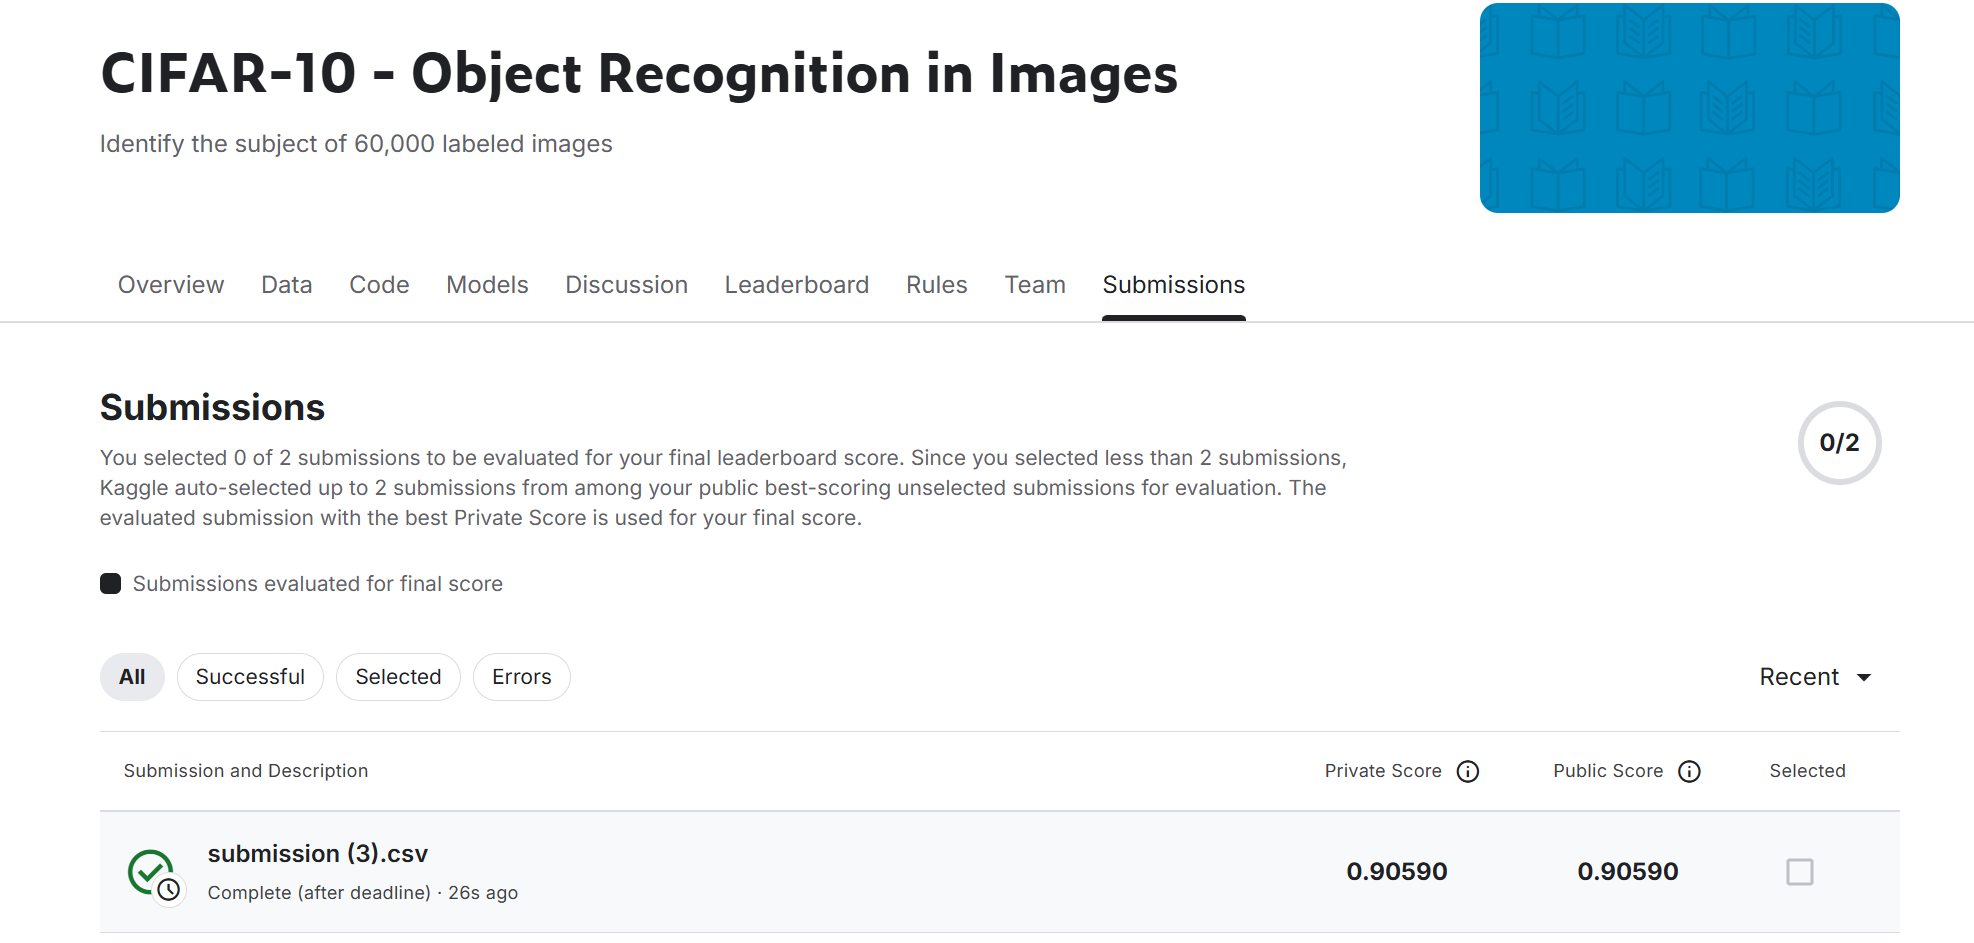